<a href="https://colab.research.google.com/github/mahbodnr/Mask-Detection/blob/main/ProjectBrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Brain 
**Transforming the World of Artificial Intelligence**

## Useful Links:

https://trello.com/b/hJpzoh2u/project-brain

https://meet.google.com/cux-mgbc-nib

https://t.me/joinchat/QyTUafkr6jZjOTE0



#TODO:


- <s>neuron id (Mahbod)</s>
- <s>define a global timestep (Mahbod)</s>
- <s>add STDP (Mahbod)</s>
- <s>add reward modulated STDP (Mahbod)</s>
- <s>Create RL agent and environment super classes (Hafez)</s>
- <s>add integrate-and-fire Model (Hafez)</s>
- Adjust the learning mechanism of neuron group class to be compatible with the agent's take_action class (decide and learn methods) (Hafez, Mahbod, Erfun)
- Think about the encode_observation method in the agent class (Hafez, Mahbod, Erfun)
- One-dimensional gridworld RL (Hafez, Erfun)
- Two and three-dimensional gridworld RL (Hafez, Erfun)
- Update LIF model (one-timepoint model) (Mahbod)

#Later:
- test Izhikevich model (Hafez)
- Test Mehmun's bachelor thesis (Hafez)

In [1]:
# Build-in libraries
import random
from abc import ABCMeta, abstractmethod, ABC
import time
import warnings
from itertools import count
# 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from tqdm.notebook import tqdm
import PIL
import cv2
# Notebook set-ups
# Disable matplotlib inline mode:
%matplotlib notebook

# Elements

## Neuron

### Neuron Types

In [2]:
class NeuronType(ABC):
    def __init__(self, dt):
        self.dt = dt
        self.mode = None

In [3]:
class IF(NeuronType):
    def __init__(self, dt, Cm = 0.1):
        """
        Simple Integrate-and-Fire Neural Model:
        Assumes a fully-insulated memberane with resistance approaching infinity
        """
        super().__init__(dt)
        self.Cm = Cm #uF
        self.mode = 'if'

    def __call__(self, current, timestep, potential):
        #TODO: debug
        return (timestep * current[timepoint])/self.Cm

#### LIF<br>
$u = u_r + \int 1/C * exp(t-t'/\tau) * I(t')dt'$

$Vm[i] = Vm[i-1] + (-Vm[i-1] + I*Rm) / tau_m * dt$

In [4]:
class LIF(NeuronType):
    def __init__(self, dt, Rm = 1, Cm = 0.1):
        """
        Leaky Integrate-and-Fire Neural Model
        """
        super().__init__(dt)
        self.Rm = Rm #ohm
        self.Cm = Cm #uF
        self.tau_m = Rm*Cm
        self.mode = 'lif'

    def __call__(self, current, previous_potential):
        return (-previous_potential+current*self.Rm) / self.tau_m* self.dt

#### Izhikevich model
https://www.izhikevich.org/publications/spikes.htm
http://www.columbia.edu/cu/appliedneuroshp/Spring2018/Spring18SHPAppliedNeuroLec5.pdf
https://stackoverflow.com/questions/53745156/izhikevich-neuron-model-equations


In [5]:
class Izhikevich(NeuronType):
    def __init__(self, dt, u_rest=-68, a=0.02, b=0.2, c =-65, d=2,
                 c1=0.04, c2=5, c3=140, c4=1, c5=1, v_rest=30):
        """Izhikevich Neural Model"""
        super().__init__(dt)
        self.c = c  #mv
        self.d = d  #mv
        self.c1 = c1    #mv/ms
        self.c2 = c2    #1/ms
        self.c3 = c3    #mv/ms
        self.c4 = c4    #1/ms
        self.c5 = c5    #mv.ohm/(ms^2.A)
        self.a = a  # dimless
        self.b = b  # dimless
        self.mode = 'izh'
        self.u_rest = u_rest

    def __call__(self, current, timestep, last_spike_timepoint, v_init, recovery):
        v = v_init
        for timepoint in range(last_spike_timepoint, timestep + 1):
            v += self.c1*(v**2)\
                + self.c2*v+self.c3-self.c4*recovery+self.c5*current[timepoint]
            recovery += self.a*(self.b*v-recovery)
        return v, recovery

### Single Neuron

In [6]:
class Neuron(object):
    _ids = count(0)
    def __init__(self, total_timepoints, dt, model,
                 neurotransmitter = 'excitatory', tau_ref = 0.002, u_rest = -68,
                 u_thresh = +30, save_potential_history = False,
                 save_current_history=False):
        """
        Define a new Neuron object
        Args:

        """
        self.id = next(self._ids)
        self.total_timepoints = total_timepoints
        self.model = model
        self.neurotransmitter = neurotransmitter
        ### TODO: add dt to __init__ => tauref = teu_ref/ dt
        self.tau_ref = tau_ref / dt #s => timepoints # refractory period
        self.u_rest = u_rest #mv
        self.u_thresh = u_thresh #mv
        self.u = self.u_rest
        self.save_potential = save_potential_history
        self.save_current = save_current_history
        self.open = True
        if self.save_current:
            self.current_history = np.zeros(total_timepoints)
        self.spike_train =  np.zeros(total_timepoints, dtype = np.bool)
        self.spike_timepoints = []
        self.last_spike_timepoint = 0
        if self.save_potential:
            self.potential = np.zeros(total_timepoints)
        self.connected_to_external_source = False
        self.current = 0
        self.timestep = 0
        if self.model.mode == 'izh':
            self.recovery = self.model.u_rest*self.model.b
        self.refactory_time = 0
        
    def step(self):
        assert self.timestep < self.total_timepoints, "Simulation interval has finished!"
        # Check refactory interval
        if not self.open:
            if self.refactory_time < self.tau_ref - 1:
                self.refactory_time += 1
            else:
                self.open = True
        else:
            # Update
            if self.model.mode == 'lif':
                self.u += self.model(self.current, self.u)
            if self.model.mode == 'izh':
                # TODO:
                self.u, self.recovery = self.model(self.current_history, self.timestep, self.last_spike_timepoint, self.u, self.recovery)
            #TODO: add save history (include both)
            # Save potential history
            if self.save_current:
                self.current_history[self.timestep] = self.current
            if self.save_potential:
                self.potential[self.timestep] = self.u
            # Spike
            if self.u >= self.u_thresh:
                self.spike_timepoints.append(self.timestep)
                self.spike_train[self.timestep] = True
                self.open = False
                self.refactory_time = 0 
                if self.model.mode == 'izh':
                    self.recovery += self.model.d
                self.u = self.u_rest
        # Empty neuron's current
        self.current = 0

    @property
    def spike(self):
        return self.spike_train[self.timestep - 1]


    def display_spikes(self):
        spike_train = self.spike_train.astype(str)
        spike_train[spike_train=='True'] = '|'
        spike_train[spike_train=='False'] =  " "
        return ''.join(np.array2string(spike_train).split("'")[1:-1:2])

## Neuron Group

In [40]:
class NeuronGroup(object):
    _ids = count(0)
    order = 1
    def __init__(self, population, total_timepoints, dt, neuron_model = LIF,
                 connection_chance=1/10, inhibition_rate= 2/10,
                 base_current = 50, online_learning_rule = None,
                 save_gif = False,
                 ):
        """
        Parameters
        ----------
        online_learning_rule: a Learning class

        """
        self.id = next(self._ids)
        self.dt = dt
        self.total_timepoints = total_timepoints
        self.population = population
        self.base_current = base_current
        self.online_learning_rule = online_learning_rule(dt) if online_learning_rule is not None else None
        self.save_gif = save_gif
        if save_gif:
            warnings.warn('WARNING: "save_gif" is set to True, it can considerably slow down the simulation process. To see the result use "save_gif_to" function after training')
            self.images = []
        self.neurons = {
            Neuron(total_timepoints, dt, model = neuron_model(dt = dt), 
                   neurotransmitter = 'excitatory' if random.random() > inhibition_rate else 'inhibitory')
            for _ in range(self.population)} 
        self.network = nx.DiGraph()
        self.network.add_nodes_from(self.neurons)
        for PreSN in self.network.nodes:
            for PostSN in self.network.nodes:
                if PreSN != PostSN:
                    if random.random() < connection_chance:
                        self.network.add_edge(PreSN, PostSN, weight = np.random.randn(1))
        self.pos = None
        self.timestep = 0
 
    def step(self):
        self.active_neurons = set()
        for neuron in self.neurons:
            neuron.timestep = self.timestep
            neuron.step()
            if neuron.spike:
                self.active_neurons.add(neuron)
 
        for neuron in self.active_neurons:
            for preSN, postSN, weight in self.network.out_edges(neuron, data = 'weight'):
                if postSN.open:
                    postSN.current += (-1 if preSN.neurotransmitter == 'inhibitory' else +1) * self.base_current * weight
            if self.online_learning_rule:
                self.online_learning_rule(self.network, neuron)
 
 
        if self.save_gif:
            fig, _ = self.draw_graph()
            self.images.append(self._fig_to_PIL_image(fig))
    
    ### Visualization
    def set_pos(self):
        input_neurons = set()
        for neuron in self.neurons:
            if neuron.connected_to_external_source:
                input_neurons.add(neuron)
        self.pos = {}
        for y, neuron in enumerate(input_neurons):
            self.pos[neuron] = (0, (y+1) / (len(input_neurons)+1))
        last_layer = input_neurons
        for x in range(1, len(self.network.nodes())):
            counted_neurons = set(self.pos.keys()) 
            next_layer = set()
            for neuron in last_layer:
                next_layer.update(self.network.successors(neuron))
            new_neurons = next_layer - counted_neurons
            if new_neurons == set():
                break
            else:
                for y, neuron in enumerate(new_neurons):
                    self.pos[neuron] = (x, (y+1)/(len(new_neurons)+1))
            last_layer = next_layer
    
    def draw_graph(self, display_ids = False):
        # Set graph position 
        if not self.pos:
            self.set_pos()
 
        fig, ax = plt.subplots(figsize=(10,8))
        nx.draw_networkx_edges(self.network, pos=self.pos, ax=ax, edge_color="gray")
        inactive_neurons = nx.draw_networkx_nodes(self.network, pos=self.pos, ax=ax,
            nodelist=set(self.network.nodes()) - (group.active_neurons),
            node_color="gray",)
        inactive_neurons.set_edgecolor("black")
        active_neurons = nx.draw_networkx_nodes(self.network, pos=self.pos, ax = ax,
                                             nodelist=group.active_neurons,
                                             node_color='blue',)
        active_neurons.set_edgecolor("black")
        if display_ids:
            nx.draw_networkx_labels(group.network, pos = self.pos, ax = ax,
                labels = {neuron: neuron.id for neuron in group.network.nodes})
        return fig, ax
            
    def _fig_to_PIL_image(self, fig):
        fig.savefig("test.jpg")
        img = cv2.imread("test.jpg")
        return PIL.Image.fromarray(img)
 
    def save_gif_to(self, path, **kwargs):
        assert self.save_gif, "No gif has been saved during the simulation. To use this function you must set 'save_gif' to True"
        frame0 = self.images.pop(0)
        frame0.save(path, save_all=True, append_images=self.images, **kwargs)
 
    def display_spikes(self):
        spike_train = ' id\n' + '=' * 5 + '╔' + '═' * self.total_timepoints + '╗\n'
        for neuron in self.neurons:
            spike_train += str(neuron.id) + ' ' * (5 - len(str(neuron.id))) \
            + '║' + neuron.display_spikes() + '║\n'  
        spike_train +=' ' * 5 + '╚' + '═' * self.total_timepoints + '╝'
        print(spike_train)

## Stimulus

In [11]:
class Stimulus(object):
    _ids = count(0)
    order = 0
    def __init__(self, output, dt):
        """
        Parameters
        ----------
        output: function
        A function that determines the output of the stimulus
        in a specific timestep.
        examples:
        output = lambda t: np.sin(2 * t)
        output = lambda t: 2

        Returns
        -------
        Returns the value of output if no connection is set.
        otherwise, sends the value to the connection (returns None).
        """
        self.output = output
        self.connection = None
        self.id = next(self._ids)
        self.timestep = 0
        self.dt = dt

    def connect(self, connection):
        connection.connected_to_external_source = True
        self.connection = connection

    def step(self):
        if self.connection is None:
            warnings.warn(f"WARNING: Stimulus (id: {self.id}) has not connected to any object!")
            return self.output(self.timestep * self.dt)
        self.connection.current += self.output(self.timestep * self.dt)

    @property
    def value(self):
        return self.output(self.timestep * self.dt)


#Learning

In [8]:
class Learning(object):
    def __init__(self):
        self.reward_based = False

## Online Learning

### FSTDP

In [31]:
class FSTDP_online(Learning):
    def __init__(self, dt,
                 interval_time = 0.01, # seconds
                 pre_post = 1,
                 post_pre = -1,
                 **kwargs):
        """
        Flat STDP
        """
        super().__init__()
        self.interval = interval_time / dt #timepoints
        self.pre_post = pre_post
        self.post_pre = post_pre

    def __call__(self, network, neuron):
        current_timestep = neuron.timestep
        for preSN in network.predecessors(neuron):
            if preSN.spike_timepoints:
                diff = current_timestep - preSN.spike_timepoints[-1]
                if diff < self.interval:
                    network.edges.get((preSN, neuron))['weight'] += np.array([self.pre_post]) 
        for postSN in network.successors(neuron):
            if postSN.spike_timepoints:
                diff = current_timestep - postSN.spike_timepoints[-1]
                if diff < self.interval:
                    network.edges.get((neuron, postSN))['weight'] += np.array([self.post_pre]) 


### Reward-modulated Flat STDP 

In [33]:
class RFSTDP_online(Learning):
    def __init__(self, dt,
                 interval_time = 0.01, # seconds
                 pre_post = 1,
                 reward_pre_post = 2,
                 post_pre = -1,
                 reward_post_pre = 1,
                 ):
        """
        Reward-modulated Flat STDP 
        """
        super().__init__()
        self.reward_based = True
        self.interval = interval_time / dt #timepoints
        self.pre_post = pre_post
        self.post_pre = post_pre
        self.reward_pre_post = reward_pre_post
        self.reward_post_pre = reward_post_pre
        self.reward = False

    def __call__(self, network, neuron):
        current_timestep = neuron.timestep
        for preSN in network.predecessors(neuron):
            diff = current_timestep - preSN.last_spike_timepoint
            if diff < self.interval:
                if self.reward:
                    network.edges.get((preSN, neuron))['weight'] +=\
                    np.array([self.reward_pre_post]) 
                else:
                    network.edges.get((preSN, neuron))['weight'] +=\
                    np.array([self.pre_post]) 

        for postSN in network.successors(neuron):
            diff = current_timestep - postSN.last_spike_timepoint
            if diff < self.interval:
                if self.reward:
                    network.edges.get((neuron, postSN))['weight'] +=\
                    np.array([self.reward_post_pre]) 
                else:
                    network.edges.get((neuron, postSN))['weight'] +=\
                    np.array([self.post_pre]) 

    def set_reward_rule(self, reward_rule):
        self.reward_rule = reward_rule

    def set_reward(self):
        self.reward = self.reward_rule()

## Offline Learning

### Reward-modulated Flat STDP 

In [62]:
class RFSTDP(Learning):
    def __init__(self, NeuronGroup,
                 interval_time = 0.01, # seconds
                 pre_post = 1,
                 reward_pre_post = 2,
                 post_pre = -1,
                 reward_post_pre = 1,
                 ):
        """
        Reward-modulated Flat STDP 
        """
        super().__init__()
        self.group = NeuronGroup
        self.network = NeuronGroup.network
        self.dt = NeuronGroup.dt
        self.reward_based = True
        self.interval = int(interval_time / self.dt) #timepoints
        self.pre_post = pre_post
        self.post_pre = post_pre
        self.reward_pre_post = reward_pre_post
        self.reward_post_pre = reward_post_pre

    def __call__(self, reward):
        processed_neurons = set()
        for neuron in self.group.neurons:
            for preSN in self.network.predecessors(neuron):
                if preSN not in processed_neurons:
                    self._update_synapse(preSN, neuron, reward)

            for postSN in self.network.successors(neuron):
                if postSN not in processed_neurons:
                    self._update_synapse(neuron, postSN, reward)

            processed_neurons.add(neuron)

    def _update_synapse(self, preSN, postSN, reward):
        for timestep in range(self.group.total_timepoints):
            if preSN.spike_train[timestep]:
                if postSN.spike_train[timestep+1:timestep+self.interval+1].any():
                    self._update_weight("pre-post", preSN, postSN, reward)
            if postSN.spike_train[timestep]:
                if preSN.spike_train[timestep+1:timestep+self.interval+1].any():
                    self._update_weight("post-pre", preSN, postSN, reward)

    def _update_weight(self, mode, preSN, postSN, reward):
        if mode == "pre-post":
            if reward:
                self.network.edges.get((preSN, postSN))['weight'] +=\
                np.array([self.reward_pre_post]) 
            else:
                self.network.edges.get((preSN, postSN))['weight'] +=\
                np.array([self.pre_post]) 

        elif mode == "post-pre":
            if reward:
                self.network.edges.get((preSN, postSN))['weight'] +=\
                np.array([self.reward_post_pre]) 
            else:
                self.network.edges.get((preSN, postSN))['weight'] +=\
                np.array([self.post_pre]) 

        else:
            raise ValueError("'mode' must be 'pre-post' or 'post-pre'")

#Simulation

In [12]:
class Simulation(object):
    def __init__(self, total_time, dt):
        """
        """
        self.total_timepoints = int(total_time/ dt)
        self.timestep = 0
        self.objects = set()
        self.dt = dt

    def NeuronGroup(self, population, **kwargs):
        G = NeuronGroup(population, self.total_timepoints, self.dt, **kwargs)
        self.objects.add(G)
        # MNote: I am watching you:
        if G.online_learning_rule:
            self.reward_based = G.online_learning_rule.reward_based
        return G

    def Stimulus(self, output):
        stim = Stimulus(output, self.dt)
        self.objects.add(stim)
        return stim

    def step(self):
        for obj in sorted(self.objects, key= lambda obj: obj.order):
            obj.step()
            if isinstance(obj, NeuronGroup) and obj.online_learning_rule and obj.online_learning_rule.reward_based:
                obj.online_learning_rule.set_reward()
            obj.timestep = self.timestep
        self.timestep += 1

    def run(self, verbose = 1):
        if verbose == 0:
            for _ in range(self.total_timepoints):
                self.step()
        else:
            start_time = time.time()
            for _ in tqdm(range(self.total_timepoints)):
                self.step()
            run_time = time.time() - start_time
            print(f"Simulation finished in {round(run_time,2)}s")


    def reset(self):
        self.timestep =0

    @property
    def second(self):
        return self.timestep * self.dt

# Run

In [41]:
sim = Simulation(total_time= 0.1, dt = 0.001)
group = sim.NeuronGroup(30, connection_chance= 2/3,
                        online_learning_rule = None, save_gif = False,
                        base_current = 20000)
stim1 = sim.Stimulus(lambda t : 5000)
# stim2 = sim.Stimulus(lambda t : 5000 *np.sin(5*t))
# stim3 = sim.Stimulus(lambda t : 5000 * np.log(t + 1))
neurons_list = list(group.neurons)
input_neuron1 =  neurons_list[0]
# input_neuron2 =  neurons_list[1]
# input_neuron3 =  neurons_list[2]
stim1.connect(input_neuron1)
# stim2.connect(input_neuron2)
# stim3.connect(input_neuron3)

sim.run()


Simulation finished in 0.1s


In [63]:
learning = RFSTDP(group)
learning(1)

In [24]:
group.display_spikes()

 id
=====╔════════════════════════════════════════════════════════════════════════════════════════════════════╗
133  ║|   |    |    |  |  |  |  |   |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |   ║
149  ║                |    |   |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  ║
134  ║    |   |   |      |   |  |   |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |   ║
135  ║                                                                                                    ║
120  ║    |   |   |  |  |  |   |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  ║
136  ║                                                                                                    ║
121  ║  |   |   |   |   |  |    |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  | ║
137  ║  |                  |  |        |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |  |   ║
122  ║  |               

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfdbb07b50>)

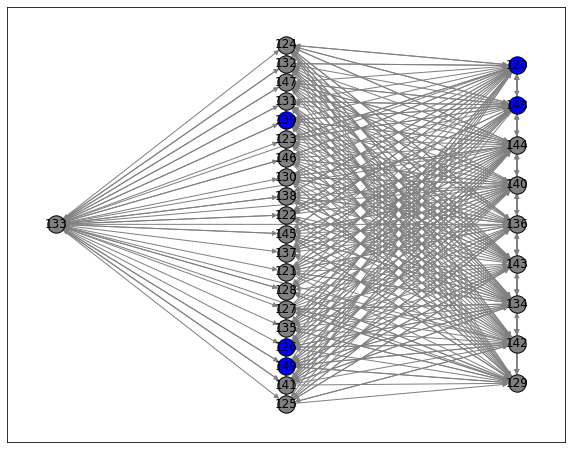

In [25]:
%matplotlib inline
group.draw_graph(display_ids= True)

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbfd2c8f350>)

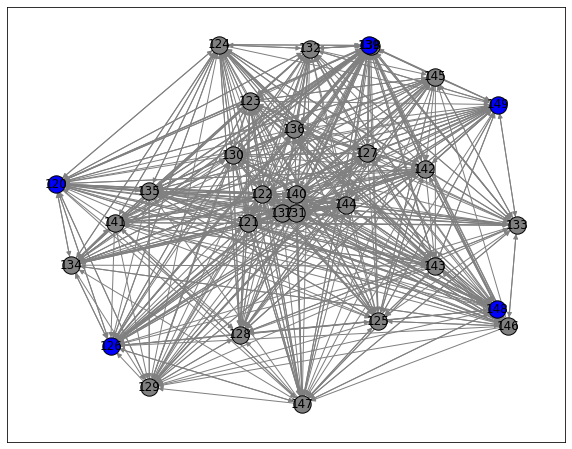

In [26]:
group.pos = nx.spring_layout(group.network)
group.draw_graph(display_ids= True)

In [ ]:
# group.save_gif_to('test.gif',  fps=2, loop=0)

# RL task


In [ ]:
class Environment(object):
    def __init__(self, action_space, state_space):
        self.action_space = action_space
        self.state_space = state_space
        self.state = None
        self.goal_state = None
        self.reset()

    def step(self, action):
        reward = self.calculate_reward(action)
        done = self.is_done()
        self.state = self.next_state(action)
        observations = self.state
        return observations, reward, done
    
    @abstractmethod
    def calculate_reward(self,action):
        pass

    @abstractmethod
    def next_state(self, action):
        pass
        
    #MNote: delete this function:    
    @abstractmethod
    def is_done(self,):
        pass

    #MNote: Chage it to setup
    @abstractmethod
    def reset(self,):
        pass

In [ ]:
class Agent(object):
    _ids = count(0)
    def __init__(self, brain, environment):
        self.id = next(_self._ids)
        self.brain = brain
        self.env = environment
        self.obs = None
        
    def take_action(self):
        action = self.brain.decide(self.env.state)
        obs, r, done = self.env.step(action)
        self.brain.learn(r)
        if done:
            self.env.reset()
    
    @abstractmethod
    def encode_observation(self, obs):
        pass

In [ ]:
class Brain(object):
    def __init__(self, id, engine, lifetime):
        self.engine = engine
        self.lifetime = lifetime
        self.id = id

    @abstractmethod
    def encode_input(self, inp, dt=0.001):
        pass

    @abstractmethod
    def decode_output(self, out):
        pass

    @abstractmethod
    def decide(self, observation):
        self.encode_input(observation) # Encode the observation to stimulus
        self.engine # Pass stimulus to the engine
        self.decode_output(engine_output) # Decode engine's output to "action"
        #return action

    @abstractmethod
    def learn(self, reward):
        pass

In [ ]:
class OneDimGridWorld(Environment):

    def __init__(self, action_space, state_space, id):
        super(OneDimGridWorld, self).__init__(action_space, state_space, id)

    def is_done(self):
        if self.state == self.goal_state:
            return True
        return False

    def reset():
        s = random.sample(range(0, self.state_space[0]), 2)
        self.state = s[0]
        self.goal_state = s[1]

    def calculate_reward(self):
        if is_done:
            reward = 1
        else:
            reward = 1/abs(self.state-self.goal_state)
            
    def next_state(self, action):
        if self.state == 0 and action == -1:
            return self.state
        if self.state == self.state_space[0]-1 and action == 1:
            return self.state
        return self.state + action

In [ ]:
class OneDimAgent(Agent):
    def __init__(self, id, brain, environment):
        super(OneDimAgent, self).__init__(id, brain, environment)

In [ ]:
class OneDimBrain(Brain):
    def __init__(self, id, engine, lifetime):
        super(OneDimBrain, self).__init__(id, engine, lifetime)

    def encode_input(self, inp, dt=0.001):
        sim = Simulation(total_time = self.lifetime, dt = dt)
        if inp != 0:
            encoded_stim = sim.Stimulus(lambda t : 5000/inp)
        else:
            encoded_stim = sim.Stimulus(lambda t : 5000)

    def decode_output(self, out):
        decoded_output = np.argmax(out)

    def decide(self, observation):
        self.encode_input(observation) # Encode the observation to stimulus
        self.engine # Pass stimulus to the engine
        self.decode_output(engine_output) # Decode engine's output to "action"
        #return action

    @abstractmethod
    def learn(self, reward):
        pass

In [ ]:
sim = Simulation(total_time= 0.05, dt = 0.001)
ReweardRule = FSTDP(sim.dt)
group = sim.NeuronGroup(30, connection_chance= 2/3,
                        online_learning_rule = ReweardRule, save_gif = False,
                        base_current = 20000)
stim1 = sim.Stimulus(lambda t : 5000)
# stim2 = sim.Stimulus(lambda t : 5000 *np.sin(5*t))
# stim3 = sim.Stimulus(lambda t : 5000 * np.log(t + 1))
neurons_list = list(group.neurons)
input_neuron1 =  neurons_list[0]
# input_neuron2 =  neurons_list[1]
# input_neuron3 =  neurons_list[2]
stim1.connect(input_neuron1)
# stim2.connect(input_neuron2)
# stim3.connect(input_neuron3)

output_neuron1 = neurons_list[-1]
output_neuron2 = neurons_list[-2]

sim.run()


Simulation finished in 0.09s


## Two Cell GridWorld
- NeuronGrop.input_neurons & NeuronGrop.output_neurons
- learning (Brain.learn())

In [ ]:
class TwoCellsGridWorld(Environment):
    def __init__(self):
        self.action_space = {0:'LEFT', 1:'RIGHT', 2:'STAY'}
        self.map = [False, True]
        self.state = 0

    def calculate_reward(self):
        self.reward = self.map[self.state]

    def next_state(self, action):
        if action == 0:
            self.state = 0
        elif action == 1:
            self.state = 1

    def step(self, action):
        self.next_state(action)
        self.calculate_reward()
        observations = self.map
        return observations, self.reward

In [ ]:
class TwoCellsAgent(Agent):
    
    def take_action(self):
        if not self.obs:
            action = self.brain.decide(self.env.map)
        else:
            action = self.brain.decide(self.obs)
        obs, r = self.env.step(action)
        self.brain.learn(r)

In [ ]:
class TwoCellsBrain(Brain):
    def __init__(self, id, engine, dt):
        super(OneDimBrain, self).__init__(id, engine, lifetime)
        self.dt = dt
        self.sim = Simulation(total_time = self.lifetime, dt = self.dt)
        self.input_neurons = engine.input_neurons
        self.output_neurons = engine.output_neurons

    def encode_input(self, inp):
        self.stim1 = self.sim.Stimulus(lambda t : 5000 * inp[0])
        self.stim1.connect(self.input_neurons[0])
        self.stim2 = self.sim.Stimulus(lambda t : 5000 * inp[1])
        self.stim2.connect(self.input_neurons[1])

    def decode_output(self):
        N1Spikes = self.output_neurons[0].spike_train.sum()
        N2Spikes = self.output_neurons[1].spike_train.sum()
        N3Spikes = self.output_neurons[2].spike_train.sum()
        maximum = max(N1Spikes, N2Spikes, N3Spikes)
        if maximum == N1Spikes:
            return 0
        elif maximum == N2Spikes:
            return 1
        else:
            return 2

    def decide(self, observation):
        self.sim.reset()
        self.encode_input(observation) # Encode the observation to stimulus
        self.sim.run() # Pass stimulus to the engine and run the Simulation
        action = self.decode_output() # Decode engine's output to "action"
        return action

    @abstractmethod
    def learn(self, reward):
        pass